# Final Models

In this notebook we look at some final candidate models and assess their performance on a validation set

In [30]:
import json
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

random.seed(17)

### Loading data

We will subsample 50,000 of the 200,000 records for training by sampling 25% of the data from each of the five music categories

In [2]:
data = None
with open(os.path.join('data', 'train.json'), 'r') as train_file:
    data = [json.loads(row) for row in train_file]

In [3]:
data_df = pd.DataFrame(data).drop(columns=['image'])
del data

In [4]:
categories = data_df['category'].unique()
dfs = []
for category in categories:
    dfs.append(data_df[data_df['category'] == category].sample(frac=0.25))
data_df = pd.concat(dfs, axis=0)
data_df = data_df.sort_index()
data_df

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash
2,4.0,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194
7,5.0,"03 3, 2016",u88679770,great,Five Stars,1456963200,Pop,$16.98,p92272123,76307426
10,3.0,"04 3, 2002",u25030850,Me personally I am not a big fan of Pearl Jam ...,Hmmmmm...........,1017792000,Pop,$6.81,p99659606,41124728
11,5.0,"11 16, 2006",u40719083,Katchen's performace throughout this collectio...,Superb interpretations by Katchen,1163635200,Classical,$31.04,p63362921,40704096
13,5.0,"06 10, 2015",u12668412,very good cd,Five Stars,1433894400,Pop,$2.43,p76494211,71863260
...,...,...,...,...,...,...,...,...,...,...
199986,5.0,"11 8, 2015",u85136324,Love it,Five Stars,1446940800,Pop,$11.88,p02978017,27368058
199989,5.0,"12 28, 2010",u92755262,I first heard Taking Back Sunday this summer w...,Great CD,1293494400,Alternative Rock,$12.97,p50896575,46693447
199990,5.0,"08 16, 2013",u74566283,She has a very beautiful voice with a great ra...,Beautiful voice,1376611200,Pop,$8.49,p25776552,47655749
199995,4.0,"05 1, 2004",u68902609,"With this, Mariah's third album, Mariah proved...",Well Done Mariah! You Show 'Em!,1083369600,Pop,$7.98,p84118731,35077372


### Pre-Processing

We apply feature cleaning as prototyped before and then split into a training and validation set, ensuring that the proportion of data points in training vs validation is consistent for each music category

In [5]:
def trim_price(price):
    """Trims `price` to remove the $ sign.
    
    If the price variable does not have the format $x.xx
    then the empty string is returned.
    
    Parameters
    ----------
    price: str
        A string representing a price.
    
    Returns
    -------
    str
        A string representing `price` but with the $ sign removed,
        or the empty string if `price` does not have the correct
        format.
    
    """
    if (not pd.isnull(price) and isinstance(price, str) and
        len(price) > 0 and price[0] == '$'):
        return price[1:]
    return ""

In [6]:
from datetime import datetime

data_df['reviewMonth'] = data_df['reviewTime'].apply(lambda x: x.split(' ')[0])
data_df['reviewYear'] = data_df['reviewTime'].apply(lambda x: x.split(' ')[2])
data_df['reviewHour'] = data_df['unixReviewTime'].apply(lambda x: datetime.fromtimestamp(x).hour)
data_df['reviewMonthYear'] = data_df['reviewYear'] + '-' + data_df['reviewMonth']

data_df['cleanedPrice'] = data_df['price'].apply(lambda x: trim_price(x))
data_df = data_df[data_df['cleanedPrice'] != ""]
data_df['cleanedPrice'] = data_df['cleanedPrice'].astype('float')

data_df['fixedReviewText'] = np.where(pd.isnull(data_df['reviewText']), "", data_df['reviewText'])
data_df['fixedSummary'] = np.where(pd.isnull(data_df['summary']), "", data_df['summary'])
data_df['fullReviewText'] = data_df['fixedSummary'] + " " + data_df['fixedReviewText']

data_df = data_df.drop(columns=['fixedReviewText', 'fixedSummary'])

genres = data_df['category'].unique()

for genre in genres:
    genre_col = "is" + genre.replace(" ", "").replace("&", "")
    data_df[genre_col] = data_df['category'].apply(lambda x: 1 if x == genre else 0)

data_df['reviewWordCount'] = data_df['fullReviewText'].apply(lambda x: len(x.split()))

data_df

<ipython-input-6-d3ba8e2e1b50>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['cleanedPrice'] = data_df['cleanedPrice'].astype('float')
<ipython-input-6-d3ba8e2e1b50>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['fixedReviewText'] = np.where(pd.isnull(data_df['reviewText']), "", data_df['reviewText'])
<ipython-input-6-d3ba8e2e1b50>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,...,reviewHour,reviewMonthYear,cleanedPrice,fullReviewText,isPop,isClassical,isJazz,isAlternativeRock,isDanceElectronic,reviewWordCount
2,4.0,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,...,20,2015-10,89.86,"Love the Music, Hate the Light Show I REALLY e...",1,0,0,0,0,133
7,5.0,"03 3, 2016",u88679770,great,Five Stars,1456963200,Pop,$16.98,p92272123,76307426,...,19,2016-03,16.98,Five Stars great,1,0,0,0,0,3
10,3.0,"04 3, 2002",u25030850,Me personally I am not a big fan of Pearl Jam ...,Hmmmmm...........,1017792000,Pop,$6.81,p99659606,41124728,...,19,2002-04,6.81,Hmmmmm........... Me personally I am not a big...,1,0,0,0,0,77
11,5.0,"11 16, 2006",u40719083,Katchen's performace throughout this collectio...,Superb interpretations by Katchen,1163635200,Classical,$31.04,p63362921,40704096,...,19,2006-11,31.04,Superb interpretations by Katchen Katchen's pe...,0,1,0,0,0,226
13,5.0,"06 10, 2015",u12668412,very good cd,Five Stars,1433894400,Pop,$2.43,p76494211,71863260,...,20,2015-06,2.43,Five Stars very good cd,1,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,5.0,"11 8, 2015",u85136324,Love it,Five Stars,1446940800,Pop,$11.88,p02978017,27368058,...,19,2015-11,11.88,Five Stars Love it,1,0,0,0,0,4
199989,5.0,"12 28, 2010",u92755262,I first heard Taking Back Sunday this summer w...,Great CD,1293494400,Alternative Rock,$12.97,p50896575,46693447,...,19,2010-12,12.97,Great CD I first heard Taking Back Sunday this...,0,0,0,1,0,43
199990,5.0,"08 16, 2013",u74566283,She has a very beautiful voice with a great ra...,Beautiful voice,1376611200,Pop,$8.49,p25776552,47655749,...,20,2013-08,8.49,Beautiful voice She has a very beautiful voice...,1,0,0,0,0,35
199995,4.0,"05 1, 2004",u68902609,"With this, Mariah's third album, Mariah proved...",Well Done Mariah! You Show 'Em!,1083369600,Pop,$7.98,p84118731,35077372,...,20,2004-05,7.98,"Well Done Mariah! You Show 'Em! With this, Mar...",1,0,0,0,0,172


In [7]:
def calculate_MSE(actuals, predicteds):
    """Calculates the Mean Squared Error between `actuals` and `predicteds`.
    
    Parameters
    ----------
    actuals: np.array
        A numpy array of the actual values.
    predicteds: np.array
        A numpy array of the predicted values.
    
    Returns
    -------
    float
        A float representing the Mean Squared Error between `actuals` and
        `predicteds`.
    
    """
    return (((actuals - predicteds)**2).sum()) / (len(actuals))

In [8]:
from sklearn.model_selection import train_test_split

genres = data_df['category'].unique()
X_train_set = []
X_val_set = []
y_train_set = []
y_val_set = []

for genre in genres:
    genre_df = data_df[data_df['category'] == genre]
    targets = genre_df['overall']
    feature_data = genre_df.drop(columns=['overall'])
    X_train, X_val, y_train, y_val = train_test_split(
        feature_data, targets, shuffle=True, test_size=0.2, random_state=17)
    X_train_set.append(X_train)
    X_val_set.append(X_val)
    y_train_set.append(y_train)
    y_val_set.append(y_val)

X_train = pd.concat(X_train_set)
X_val = pd.concat(X_val_set)
y_train = pd.concat(y_train_set)
y_val = pd.concat(y_val_set)

### Collaborative Filtering

In this model we only need a users ID, the items ID, and 

In [14]:
train_data = pd.concat([X_train, pd.DataFrame(y_train, columns=['overall'])], axis=1)
val_data = pd.concat([X_val, pd.DataFrame(y_val, columns=['overall'])], axis=1)

In [15]:
import scipy.sparse as sp

item_matrix = train_data.pivot(index='itemID', columns='reviewerID', values='overall')
item_matrix = item_matrix.fillna(0)
user_item_train_matrix = sp.csr_matrix(item_matrix.values)

In [16]:
train_item_avg = train_data.groupby(train_data['itemID'], as_index=False)['overall'].mean()
train_item_avg.columns = ['itemID', 'itemAverage']
train_item_avg = train_item_avg.set_index('itemID')

In [17]:
from sklearn.neighbors import NearestNeighbors

def build_knn_model(train_matrix, k):
    """Builds a kNN model on `train_matrix` with `k` neighbours.
    
    Parameters
    ----------
    train_matrix: sp.csr_matrix
        The sparse matrix used to build the kNN model.
    k: int
        The number of neighbours to use in the kNN model.
    
    Returns
    -------
    NearestNeighbors
        A NearestNeighbors model fit to `train_matrix`.
    
    """
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k)
    model_knn.fit(train_matrix)
    return model_knn

In [18]:
def get_item_preds_from_knn(knn_model, train_matrix, items, item_avgs):
    """Gets the kNN predictions for the items in `items`.
    
    This assumes that every item in items was fit on the
    knn_model. This is just a precomputation step to get
    the predictions for items in the training set.
    
    Parameters
    ----------
    knn_model: NearestNeighbors
        A NearestNeighbors model that has been fit.
    train_matrix: sp.csr_matrix
        The sparse matrix representing the training data.
    items: np.array
        An array of item indices for items in `knn_model`.
    item_avgs: pd.DataFrame
        A pandas dataframe containing the average rating for
        each item in `items`.
    
    Returns
    -------
    pd.DataFrame
        A DataFrame containing the predicted rating for each item
        in `items`.
    
    """
    item_neighbors = np.asarray(knn_model.kneighbors(train_matrix, return_distance=False))
    knn_avgs = np.zeros(len(item_neighbors))   # this is more efficient than appending multiple times (no resizing)
    for i in range(len(item_neighbors)):
        knn_avgs[i] = item_avgs['itemAverage'][items[item_neighbors[i]]].mean()    # average of average ratings for neighbors
    return pd.concat([pd.DataFrame(items, columns=['itemID']),
                      pd.DataFrame(knn_avgs, columns=['itemRating'])],
                    axis=1)

In [19]:
def predict_ratings(X, item_preds, default_val, merge_col):
    """Predicts the item ratings for the items in `X`.
    
    Parameters
    ----------
    X: pd.DataFrame
        The DataFrame of features.
    item_preds: pd.DataFrame
        The DataFrame of predicted ratings for the items.
    default_val: float
        A default rating used for unseen items.
    merge_col: str
        The column to merge on.
    
    Returns
    -------
    pd.DataFrame
        A DataFrame containing the predicted item ratings for
        the records in `X`.
    
    """
    id_col = "{}ID".format(merge_col)
    rating_col = "{}Rating".format(merge_col)
    df_item = pd.merge(X, item_preds, how='left', on=[id_col])
    df_item[rating_col] = df_item[rating_col].fillna(default_val)
    df_item.index = X.index
    return df_item[rating_col]

In [20]:
def get_item_knn_train_validation_preds(train_df, val_df, train_matrix, k, items, item_avgs):
    """Gets predictions on `train_df` and `val_df` from a kNN model.
    
    Parameters
    ----------
    train_df: pd.DataFrame
        A DataFrame of the training data.
    val_df: pd.DataFrame
        A DataFrame of the validation data.
    train_matrix: sp.csr_matrix
        The sparse matrix used to train the kNN model.
    k: int
        The number of neighbours in the kNN model.
    items: np.array
        An array of strings representing the ids of the
        items used in training.
    item_avgs: pd.DataFrame
        A DataFrame containing the average rating for the
        items in `items`.
    
    Returns
    -------
    np.array, np.array
        Arrays of predictions on the training and validation sets, respectively.
    
    """
    knn_model = build_knn_model(train_matrix, k)
    knn_preds = get_item_preds_from_knn(knn_model, train_matrix, items, item_avgs)
    
    # prediction for a new item
    new_item_vec = np.zeros(train_matrix.shape[1])
    new_item_neighbours = knn_model.kneighbors(new_item_vec.reshape(1, -1), return_distance=False)
    new_item_pred = item_avgs['itemAverage'][items[new_item_neighbours[0]]].mean()
    
    train_pred = predict_ratings(train_df, knn_preds, new_item_pred, "item")
    val_pred = predict_ratings(val_df, knn_preds, new_item_pred, "item")
    return train_pred, val_pred

In [21]:
k_vals = [1, 2, 5, 10]

for k in k_vals:
    print("kNN with k = {}".format(k))
    print("---------------")
    train_preds, val_preds = get_item_knn_train_validation_preds(
        train_data, val_data, user_item_train_matrix, k, item_matrix.index, train_item_avg)
    print("Training MSE: {}".format(calculate_MSE(train_preds, train_data['overall'])))
    print("Validation MSE: {}".format(calculate_MSE(val_preds, val_data['overall'])))
    print()

kNN with k = 1
---------------
Training MSE: 0.6151542294412382
Validation MSE: 1.185150949731069

kNN with k = 2
---------------
Training MSE: 0.8269103223074389
Validation MSE: 1.15457843024626

kNN with k = 5
---------------
Training MSE: 0.9124537192157918
Validation MSE: 1.0261925560216598

kNN with k = 10
---------------
Training MSE: 0.9356363864024619
Validation MSE: 1.0042670132101166



In [24]:
user_matrix = train_data.pivot(index='reviewerID', columns='itemID', values='overall')
user_matrix = user_matrix.fillna(0)
user_item_train_matrix = sp.csr_matrix(user_matrix.values)

In [32]:
train_user_avg = train_data.groupby(train_data['reviewerID'], as_index=False)['overall'].mean()
train_user_avg.columns = ['reviewerID', 'reviewerAverage']
train_user_avg = train_user_avg.set_index('reviewerID')

In [42]:
def get_user_preds_from_knn(knn_model, train_matrix, users, user_avgs):
    """Gets the kNN predictions for the user in `users`.
    
    This assumes that `knn_model` was fit on every user in 
    `users`. This is just a precomputation step to get
    the predictions for users in the training set.
    
    Parameters
    ----------
    knn_model: NearestNeighbors
        A NearestNeighbors model that has been fit.
    train_matrix: sp.csr_matrix
        The sparse matrix representing the training data.
    users: np.array
        An array of user ids for users in `knn_model`.
    user_avgs: pd.DataFrame
        A pandas dataframe containing the average rating for
        each user in `users`.
    
    Returns
    -------
    pd.DataFrame
        A DataFrame containing the predicted rating for each user
        in `users`.
    
    """
    user_neighbors = np.asarray(knn_model.kneighbors(train_matrix, return_distance=False))
    knn_avgs = np.zeros(len(user_neighbors))   # this is more efficient than appending multiple times (no resizing)
    for i in range(len(user_neighbors)):
        knn_avgs[i] = user_avgs['reviewerAverage'][users[user_neighbors[i]]].mean()    # average of average ratings for neighbors
    return pd.concat([pd.DataFrame(users, columns=['reviewerID']),
                      pd.DataFrame(knn_avgs, columns=['reviewerRating'])],
                    axis=1)

In [45]:
def get_user_knn_train_validation_preds(train_df, val_df, train_matrix, k, users, user_avgs):
    """Gets predictions on `train_df` and `val_df` from a kNN model.
    
    Parameters
    ----------
    train_df: pd.DataFrame
        A DataFrame of the training data.
    val_df: pd.DataFrame
        A DataFrame of the validation data.
    train_matrix: sp.csr_matrix
        The sparse matrix used to train the kNN model.
    k: int
        The number of neighbours in the kNN model.
    users: np.array
        An array of strings representing the ids of the
        users used in training.
    user_avgs: pd.DataFrame
        A DataFrame containing the average rating for the
        users in `users`.
    
    Returns
    -------
    np.array, np.array
        Arrays of predictions on the training and validation sets, respectively.
    
    """
    knn_model = build_knn_model(train_matrix, k)
    knn_preds = get_user_preds_from_knn(knn_model, train_matrix, users, user_avgs)
    
    # prediction for a new user
    new_user_vec = np.zeros(train_matrix.shape[1])
    new_user_neighbours = knn_model.kneighbors(new_user_vec.reshape(1, -1), return_distance=False)
    new_user_pred = user_avgs['reviewerAverage'][users[new_user_neighbours[0]]].mean()
    
    train_pred = predict_ratings(train_df, knn_preds, new_user_pred, "reviewer")
    val_pred = predict_ratings(val_df, knn_preds, new_user_pred, "reviewer")
    return train_pred, val_pred

In [46]:
k_vals = [1, 2, 5, 10]

for k in k_vals:
    print("kNN with k = {}".format(k))
    print("---------------")
    train_preds, val_preds = get_user_knn_train_validation_preds(
        train_data, val_data, user_item_train_matrix, k, user_matrix.index, train_user_avg)
    print("Training MSE: {}".format(calculate_MSE(train_preds, train_data['overall'])))
    print("Validation MSE: {}".format(calculate_MSE(val_preds, val_data['overall'])))
    print()

kNN with k = 1
---------------
Training MSE: 0.6976994353937871
Validation MSE: 1.253129016513731

kNN with k = 2
---------------
Training MSE: 0.920613376246797
Validation MSE: 1.6157140669012258

kNN with k = 5
---------------
Training MSE: 0.836200292189724
Validation MSE: 1.1936500936072167

kNN with k = 10
---------------
Training MSE: 0.8726691799530596
Validation MSE: 1.0170220310726248



### Language Models

The first languge model is built with TfidfVectorizer (Term Frequency - Inverse Document Frequency)

In [9]:
columns_to_keep = ['cleanedPrice', 'isPop', 'isAlternativeRock', 'isJazz', 'isClassical', 'isDanceElectronic', 'reviewWordCount']
X_train_reg1 = X_train[columns_to_keep]
X_val_reg1 = X_val[columns_to_keep]

In [10]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_reg1['reviewWordCount'] = X_train_reg1['reviewWordCount'].apply(lambda x: np.log(x))
X_val_reg1['reviewWordCount'] = X_val_reg1['reviewWordCount'].apply(lambda x: np.log(x))

<ipython-input-10-2b5d7d7878ed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reg1['reviewWordCount'] = X_train_reg1['reviewWordCount'].apply(lambda x: np.log(x))
<ipython-input-10-2b5d7d7878ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reg1['reviewWordCount'] = X_val_reg1['reviewWordCount'].apply(lambda x: np.log(x))


In [11]:
def clean_dataset(df):
    """Cleans the dataset `df`. Removing null values.
    
    Parameters
    ----------
    df: pd.DataFrame
        The dataframe to be cleaned.
    
    Returns
    -------
    pd.DataFrame
        The cleaned dataframe obtained from `df`.
    
    """
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [12]:
X_train_reg1 = clean_dataset(X_train_reg1)
y_train1 = y_train[y_train.index.isin(X_train_reg1.index)]
X_train1 = X_train[X_train.index.isin(X_train_reg1.index)]

X_val_reg1 = clean_dataset(X_val_reg1)
y_val1 = y_val[y_val.index.isin(X_val_reg1.index)]
X_val1 = X_val[X_val.index.isin(X_val_reg1.index)]

<ipython-input-11-6ec09020000d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-11-6ec09020000d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
X_train_mod = X_train_mod[X_train_mod.index.isin(X_train_reg1.index)]
X_val_mod = X_val_mod[X_val_mod.index.isin(X_val_reg1.index)]

In [22]:
X_train_reg1 = min_max_scaler.fit_transform(X_train_reg1)
X_val_reg1 = min_max_scaler.transform(X_val_reg1)

In [103]:
from sklearn.linear_model import Ridge

vthreshold_rating = np.vectorize(threshold_rating)

alphas = [0.0, 0.01, 0.03, 0.1, 0.3]
for alpha in alphas:
    print("Alpha = {}".format(alpha))
    print("------------")
    reg_model = Ridge(alpha=alpha)
    reg_model.fit(X_train_reg1, y_train1)
    print("Training Error: {}".format(calculate_MSE(y_train1, vthreshold_rating(reg_model.predict(X_train_reg1)))))
    print("Validation Error: {}".format(calculate_MSE(y_val1, vthreshold_rating(reg_model.predict(X_val_reg1)))))
    print()

Alpha = 0.0
------------
Training Error: 0.9588535445992827
Validation Error: 0.9262869599431929

Alpha = 0.01
------------
Training Error: 0.9588428957078677
Validation Error: 0.9262350113636552

Alpha = 0.03
------------
Training Error: 0.9588433477027621
Validation Error: 0.9262349757449848

Alpha = 0.1
------------
Training Error: 0.9588449304068484
Validation Error: 0.926234860637202

Alpha = 0.3
------------
Training Error: 0.9588494564503761
Validation Error: 0.9262346102237373



In [23]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def process_review_text(review_text, exclude_text, ps):
    """Pre-processes the text given by `review_text`.
    
    Parameters
    ----------
    review_text: str
        The review text to be processed.
    exclude_text: collection
        A collection of words to be excluded.
    ps: PorterStemmer
        The PorterStemmer used to perform word stemming.
    
    Returns
    -------
    str
        A string representing the processed version of `review_text`.
    
    """
    review = re.sub('[^a-zA-Z0-9]', ' ', review_text).lower().split()
    review = [ps.stem(word) for word in review if not word in exclude_text]
    return ' '.join(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Matthew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
exclude_english = set(stopwords.words('english'))
ps = PorterStemmer()
X_train1['processedReview'] = X_train1['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))
X_val1['processedReview'] = X_val1['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))

<ipython-input-24-0d22f415ca83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train1['processedReview'] = X_train1['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))


In [28]:
full_text = " ".join(list(X_train1['processedReview'])) + " "

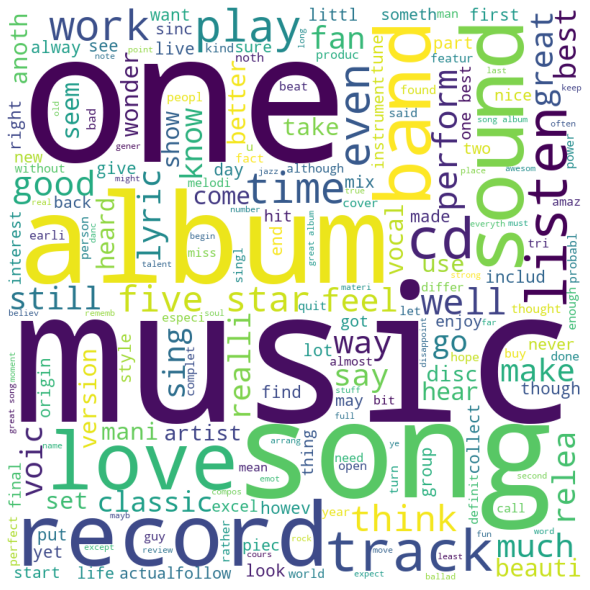

In [32]:
from wordcloud import WordCloud

word_cloud = WordCloud(width=800, height=800,
                       background_color='white',
                       min_font_size=10).generate(full_text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

##### TFIDF Model

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X_train_cv1 = cv.fit_transform(X_train1['processedReview'])
X_val_cv1 = cv.transform(X_val1['processedReview'])

In [32]:
import scipy.sparse as sp

X_train_reg1_sp = sp.csr_matrix(X_train_reg1)
X_train_cv_reg1 = sp.hstack((X_train_cv1, X_train_reg1_sp), format='csr')

X_val_reg1_sp = sp.csr_matrix(X_val_reg1)
X_val_cv_reg1 = sp.hstack((X_val_cv1, X_val_reg1_sp), format='csr')

In [35]:
from xgboost import XGBRegressor

learning_rates = [0.03, 0.1, 0.3, 0.5]
estimators = [50, 100, 200, 500, 1000, 2000]
depths = [1, 2, 5]

for learning_rate in learning_rates:
    for estimator in estimators:
        for depth in depths:
            print("Learning Rate: {0}, # Estimators: {1}, Depth: {2}".format(learning_rate, estimator, depth))
            print("--------------------------------------------------")
            xg_reg = XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, n_estimators=estimator)
            xg_reg.fit(X_train_cv_reg1, y_train1)
            print("Training Error: {}".format(calculate_MSE(y_train1, vthreshold_rating(xg_reg.predict(X_train_cv_reg1)))))
            print("Validation Error: {}".format(calculate_MSE(y_val1, vthreshold_rating(xg_reg.predict(X_val_cv_reg1)))))
            print()

Learning Rate: 0.03, # Estimators: 50, Depth: 1
--------------------------------------------------
Training Error: 1.657059470470493
Validation Error: 1.643835435274604

Learning Rate: 0.03, # Estimators: 50, Depth: 2
--------------------------------------------------
Training Error: 1.6152387609816117
Validation Error: 1.6027478863791698

Learning Rate: 0.03, # Estimators: 50, Depth: 5
--------------------------------------------------
Training Error: 1.5064334150057164
Validation Error: 1.5156320233080705

Learning Rate: 0.03, # Estimators: 100, Depth: 1
--------------------------------------------------
Training Error: 0.9278305199606406
Validation Error: 0.9140717888445251

Learning Rate: 0.03, # Estimators: 100, Depth: 2
--------------------------------------------------
Training Error: 0.8659974631467421
Validation Error: 0.8564736279922335

Learning Rate: 0.03, # Estimators: 100, Depth: 5
--------------------------------------------------
Training Error: 0.7210557554945155
Valid

Validation Error: 0.5755454593030278

Learning Rate: 0.3, # Estimators: 1000, Depth: 1
--------------------------------------------------
Training Error: 0.47510323441389246
Validation Error: 0.5700952445865527

Learning Rate: 0.3, # Estimators: 1000, Depth: 2
--------------------------------------------------
Training Error: 0.34608801412853196
Validation Error: 0.5653763316636292

Learning Rate: 0.3, # Estimators: 1000, Depth: 5
--------------------------------------------------
Training Error: 0.12860696671980432
Validation Error: 0.5820806629028914

Learning Rate: 0.3, # Estimators: 2000, Depth: 1
--------------------------------------------------
Training Error: 0.4057182092140655
Validation Error: 0.5615677713800927

Learning Rate: 0.3, # Estimators: 2000, Depth: 2
--------------------------------------------------
Training Error: 0.2572209693941599
Validation Error: 0.5717024770539526

Learning Rate: 0.3, # Estimators: 2000, Depth: 5
---------------------------------------------

It seems that `learning_rate=0.1`, `n_estimators=2000`, and `max_depth=1` provides a very good model

In [36]:
from xgboost import XGBRegressor
xg_reg = XGBRegressor(learning_rate=0.1, n_estimators=2000, max_depth=1)
xg_reg.fit(X_train_cv_reg1, y_train1)

train_MSE = calculate_MSE(y_train1, vthreshold_rating(xg_reg.predict(X_train_cv_reg1)))
val_MSE = calculate_MSE(y_val1, vthreshold_rating(xg_reg.predict(X_val_cv_reg1)))

print("Training error based on XGBoost CountVectorizer prediction: %.3f" % train_MSE)
print("Validation error based on XGBoost CountVectorizer prediction: %.3f" % val_MSE)

Training error based on XGBoost CountVectorizer prediction: 0.517
Validation error based on XGBoost CountVectorizer prediction: 0.579


### Word2Vec

In [79]:
from gensim.models import Word2Vec
w2v = Word2Vec(list(X_train1['processedReview']), size=350, window=10, min_count=1)

In [82]:
def create_review_vector(review_text):
    """Creates a vector for the review given by `review_text`.
    
    The word vectors for each word in the review are averaged
    to build a vector for the review.
    
    Parameters
    ----------
    review_text: str
        The review for which the vector is generated.
    
    Returns
    -------
    vector
        A vector for the review.
    
    """
    review = [word for word in review_text if word in w2v.wv.vocab]
    if len(review) > 0:
        return np.mean(w2v[review], axis=0)
    return np.zeros(350)

In [83]:
X_train1['review_vector'] = X_train1['processedReview'].apply(lambda x: create_review_vector(x))
X_val1['review_vector'] = X_val1['processedReview'].apply(lambda x: create_review_vector(x))

<ipython-input-82-07f028c5b26d>:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(w2v[review], axis=0)
<ipython-input-83-ba0c28ab83e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train1['review_vector'] = X_train1['processedReview'].apply(lambda x: create_review_vector(x))


In [84]:
def create_review_vec_df(review_vecs, indices):
    """Creates a dataframe from `review_vecs`.
    
    Each numpy array in review_vecs is converted to a 
    row in the resulting dataframe.
    
    Parameters
    ----------
    review_vecs: list
        A list of numpy arrays where each array corresponds
        to the review vector for a review.
    indicies: np.array
        A numpy array of indices for the DataFrame
    
    Returns
    -------
    pd.DataFrame
        The DataFrame obtained from converting `review_vecs`
        to a dataframe.
    
    """
    review_vec_df = pd.DataFrame(np.vstack(review_vecs))
    review_vec_df.columns = ["word" + str(col) for col in review_vec_df.columns]
    review_vec_df.index = indices
    return review_vec_df

In [85]:
X_train_wv = create_review_vec_df(X_train1['review_vector'], X_train1.index)
X_val_wv = create_review_vec_df(X_val1['review_vector'], X_val1.index)

In [86]:
X_train_reg1_df = pd.DataFrame(np.vstack(X_train_reg1))
X_train_reg1_df.index = X_train1.index

X_val_reg1_df = pd.DataFrame(np.vstack(X_val_reg1))
X_val_reg1_df.index = X_val1.index

In [87]:
X_train_wv_reg = pd.concat([X_train_wv, X_train_reg1_df], axis=1)
X_val_wv_reg = pd.concat([X_val_wv, X_val_reg1_df], axis=1)

In [88]:
from sklearn.linear_model import Ridge

alphas = [0.0, 0.01, 0.03, 0.1, 0.3]
for alpha in alphas:
    print("Alpha = {}".format(alpha))
    print("------------")
    reg_model = Ridge(alpha=alpha)
    reg_model.fit(X_train_wv_reg, y_train1)
    print("Training Error: {}".format(calculate_MSE(y_train1, vthreshold_rating(reg_model.predict(X_train_wv_reg)))))
    print("Validation Error: {}".format(calculate_MSE(y_val1, vthreshold_rating(reg_model.predict(X_val_wv_reg)))))
    print()

Alpha = 0.0
------------


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.37186e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Training Error: 0.8940535781682711
Validation Error: 0.9018064217232329

Alpha = 0.01
------------
Training Error: 0.9079188841981554
Validation Error: 0.9021185371572493

Alpha = 0.03
------------
Training Error: 0.907959198977622
Validation Error: 0.9021166181450053

Alpha = 0.1
------------
Training Error: 0.9080974389160185
Validation Error: 0.9021763444454539

Alpha = 0.3
------------
Training Error: 0.9083702951020889
Validation Error: 0.9023891975104213



In [89]:
learning_rates = [0.03, 0.1, 0.3, 0.5]
estimators = [50, 100, 200, 500, 1000, 2000]
depths = [1, 2, 5]

for learning_rate in learning_rates:
    for estimator in estimators:
        for depth in depths:
            print("Learning Rate: {0}, # Estimators: {1}, Depth: {2}".format(learning_rate, estimator, depth))
            print("--------------------------------------------------")
            xg_reg = XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, n_estimators=estimator)
            xg_reg.fit(X_train_wv_reg, y_train1)
            print("Training Error: {}".format(calculate_MSE(y_train1, vthreshold_rating(xg_reg.predict(X_train_wv_reg)))))
            print("Validation Error: {}".format(calculate_MSE(y_val1, vthreshold_rating(xg_reg.predict(X_val_wv_reg)))))
            print()

Learning Rate: 0.03, # Estimators: 50, Depth: 1
--------------------------------------------------
Training Error: 1.6765857758092944
Validation Error: 1.6647381372164318

Learning Rate: 0.03, # Estimators: 50, Depth: 2
--------------------------------------------------
Training Error: 1.6580919193530188
Validation Error: 1.647719877424904

Learning Rate: 0.03, # Estimators: 50, Depth: 5
--------------------------------------------------
Training Error: 1.608621216796498
Validation Error: 1.6276771719437315

Learning Rate: 0.03, # Estimators: 100, Depth: 1
--------------------------------------------------
Training Error: 0.9686630666825585
Validation Error: 0.96021394548407

Learning Rate: 0.03, # Estimators: 100, Depth: 2
--------------------------------------------------
Training Error: 0.9469037643105891
Validation Error: 0.9420444818347719

Learning Rate: 0.03, # Estimators: 100, Depth: 5
--------------------------------------------------
Training Error: 0.8693182573628832
Validat

KeyboardInterrupt: 

### Meta Models

In this section we look at models that combine both collaborative filtering and language models.

We start by using the predictions of the collaborative filtering as features in our language model

In [104]:
columns_to_keep = ['cleanedPrice', 'isPop', 'isAlternativeRock', 'isJazz', 'isClassical', 'isDanceElectronic', 'reviewWordCount', 'userRating', 'itemRating']
X_train_reg2 = X_train_mod[columns_to_keep]
X_val_reg2 = X_val_mod[columns_to_keep]

In [105]:
min_max_scaler = MinMaxScaler()
X_train_reg2['reviewWordCount'] = X_train_reg2['reviewWordCount'].apply(lambda x: np.log(x))
X_val_reg2['reviewWordCount'] = X_val_reg2['reviewWordCount'].apply(lambda x: np.log(x))

<ipython-input-105-d8a296a7aa94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reg2['reviewWordCount'] = X_train_reg2['reviewWordCount'].apply(lambda x: np.log(x))
<ipython-input-105-d8a296a7aa94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reg2['reviewWordCount'] = X_val_reg2['reviewWordCount'].apply(lambda x: np.log(x))


In [106]:
X_train_reg2 = clean_dataset(X_train_reg2)
y_train2 = y_train[y_train.index.isin(X_train_reg2.index)]
X_train2 = X_train[X_train.index.isin(X_train_reg2.index)]

X_val_reg2 = clean_dataset(X_val_reg2)
y_val2 = y_val[y_val.index.isin(X_val_reg2.index)]
X_val2 = X_val[X_val.index.isin(X_val_reg2.index)]

<ipython-input-100-550e8da2fe0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-100-550e8da2fe0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [107]:
X_train_reg2 = min_max_scaler.fit_transform(X_train_reg2)
X_val_reg2 = min_max_scaler.transform(X_val_reg2)

In [108]:
alphas = [0.0, 0.01, 0.03, 0.1, 0.3]
for alpha in alphas:
    print("Alpha = {}".format(alpha))
    print("------------")
    reg_model = Ridge(alpha=alpha)
    reg_model.fit(X_train_reg2, y_train2)
    print("Training Error: {}".format(calculate_MSE(y_train2, vthreshold_rating(reg_model.predict(X_train_reg2)))))
    print("Validation Error: {}".format(calculate_MSE(y_val2, vthreshold_rating(reg_model.predict(X_val_reg2)))))
    print()

Alpha = 0.0
------------
Training Error: 0.7891828923294948
Validation Error: 0.9486008427597297

Alpha = 0.01
------------
Training Error: 0.7891677848703272
Validation Error: 0.9484601751838659

Alpha = 0.03
------------
Training Error: 0.7891678465440518
Validation Error: 0.9484577298907713

Alpha = 0.1
------------
Training Error: 0.7891680642355218
Validation Error: 0.948449171698209

Alpha = 0.3
------------
Training Error: 0.7891687018526102
Validation Error: 0.9484247228291963



In [109]:
exclude_english = set(stopwords.words('english'))
ps = PorterStemmer()
X_train2['processedReview'] = X_train2['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))
X_val2['processedReview'] = X_val2['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))

<ipython-input-109-25810bf4f6a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train2['processedReview'] = X_train2['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))
<ipython-input-109-25810bf4f6a4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val2['processedReview'] = X_val2['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))


In [110]:
cv = CountVectorizer(max_features=1500)
X_train_cv2 = cv.fit_transform(X_train2['processedReview'])
X_val_cv2 = cv.transform(X_val2['processedReview'])

In [111]:
X_train_reg2_sp = sp.csr_matrix(X_train_reg2)
X_train_cv_reg2 = sp.hstack((X_train_cv2, X_train_reg2_sp), format='csr')

X_val_reg2_sp = sp.csr_matrix(X_val_reg2)
X_val_cv_reg2 = sp.hstack((X_val_cv2, X_val_reg2_sp), format='csr')

In [112]:
learning_rates = [0.01, 0.03, 0.1, 0.3, 0.5]
estimators = [50, 100, 200, 500]
depths = [1, 2, 5, 10]

for learning_rate in learning_rates:
    for estimator in estimators:
        for depth in depths:
            print("Learning Rate: {0}, # Estimators: {1}, Depth: {2}".format(learning_rate, estimator, depth))
            print("--------------------------------------------------")
            xg_reg = XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, n_estimators=estimator)
            xg_reg.fit(X_train_cv_reg2, y_train2)
            print("Training Error: {}".format(calculate_MSE(y_train2, vthreshold_rating(xg_reg.predict(X_train_cv_reg2)))))
            print("Validation Error: {}".format(calculate_MSE(y_val2, vthreshold_rating(xg_reg.predict(X_val_cv_reg2)))))
            print()

Learning Rate: 0.01, # Estimators: 50, Depth: 1
--------------------------------------------------
Training Error: 6.503735872991274
Validation Error: 6.883393063136512

Learning Rate: 0.01, # Estimators: 50, Depth: 2
--------------------------------------------------
Training Error: 6.472925759109321
Validation Error: 6.873810349242472

Learning Rate: 0.01, # Estimators: 50, Depth: 5
--------------------------------------------------
Training Error: 6.415552951975483
Validation Error: 6.766778004848318

Learning Rate: 0.01, # Estimators: 50, Depth: 10
--------------------------------------------------
Training Error: 6.336512333143151
Validation Error: 6.702224040577343

Learning Rate: 0.01, # Estimators: 100, Depth: 1
--------------------------------------------------
Training Error: 2.9116597565047635
Validation Error: 3.2502935567689333

Learning Rate: 0.01, # Estimators: 100, Depth: 2
--------------------------------------------------
Training Error: 2.868043939305317
Validation E

Training Error: 0.06626693654491513
Validation Error: 0.629127338706747

Learning Rate: 0.3, # Estimators: 50, Depth: 1
--------------------------------------------------
Training Error: 0.6695470399035651
Validation Error: 0.8320175368867865

Learning Rate: 0.3, # Estimators: 50, Depth: 2
--------------------------------------------------
Training Error: 0.5877134032041788
Validation Error: 0.7312280170602444

Learning Rate: 0.3, # Estimators: 50, Depth: 5
--------------------------------------------------
Training Error: 0.821128725428028
Validation Error: 0.6644344297462841

Learning Rate: 0.3, # Estimators: 50, Depth: 10
--------------------------------------------------
Training Error: 0.18017706776835557
Validation Error: 0.6767750787866058

Learning Rate: 0.3, # Estimators: 100, Depth: 1
--------------------------------------------------
Training Error: 0.6250522630858881
Validation Error: 0.7799276543267967

Learning Rate: 0.3, # Estimators: 100, Depth: 2
----------------------

It seems `learning_rate=0.3`, `n_estimators=200`, `max_depth=2` performs the best

In [113]:
xg_reg = XGBRegressor(learning_rate=0.3, n_estimators=200, max_depth=2)
xg_reg.fit(X_train_cv_reg2, y_train2)

train_MSE = calculate_MSE(y_train2, vthreshold_rating(xg_reg.predict(X_train_cv_reg2)))
val_MSE = calculate_MSE(y_val2, vthreshold_rating(xg_reg.predict(X_val_cv_reg2)))

print("Training error based on XGBoost CountVectorizer prediction: %.3f" % train_MSE)
print("Validation error based on XGBoost CountVectorizer prediction: %.3f" % val_MSE)

Training error based on XGBoost CountVectorizer prediction: 0.502
Validation error based on XGBoost CountVectorizer prediction: 0.652


This is actually much worse compared to the pure language model.

However, we could also create a meta model by taking a weighted average of predictions from collaborative filtering and the pure language model. We now try this for a few candidate weightings

In [114]:
weights = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

xg_reg = XGBRegressor(learning_rate=0.3, n_estimators=500, max_depth=2)
xg_reg.fit(X_train_cv_reg1, y_train1)

reg_train_preds = vthreshold_rating(xg_reg.predict(X_train_cv_reg1))
reg_val_preds = vthreshold_rating(xg_reg.predict(X_val_cv_reg1))

cf_train_preds = vthreshold_rating(X_train_mod['pred'])
cf_val_preds = vthreshold_rating(X_val_mod['pred'])

for weight in weights:
    print("Weight: %.1f" % weight)
    print("------------")
    train_MSE = calculate_MSE(y_train1, ((weight*reg_train_preds) + ((1.0 - weight)*cf_train_preds)))
    val_MSE = calculate_MSE(y_val1, ((weight*reg_val_preds) + ((1.0 - weight)*cf_val_preds)))
    print("Training error: %.3f" % train_MSE)
    print("Validation error: %.3f" % val_MSE)
    print()

Weight: 0.0
------------
Training error: 0.812
Validation error: 0.950

Weight: 0.1
------------
Training error: 0.754
Validation error: 0.882

Weight: 0.3
------------
Training error: 0.658
Validation error: 0.768

Weight: 0.5
------------
Training error: 0.587
Validation error: 0.681

Weight: 0.7
------------
Training error: 0.542
Validation error: 0.621

Weight: 0.9
------------
Training error: 0.522
Validation error: 0.589

Weight: 1.0
------------
Training error: 0.522
Validation error: 0.583



### Language and Popularity

Combining a language model with features representing how popular an item is (how many times it was rated) and how often the user rates.

In [38]:
user_rating_counts = X_train.groupby(X_train['reviewerID'])['price'].count()
item_rating_counts = X_train.groupby(X_train['itemID'])['price'].count()
user_rating_counts = pd.DataFrame(
    user_rating_counts.values, columns=['userRatingCount'], index=user_rating_counts.index).reset_index()
item_rating_counts = pd.DataFrame(
    item_rating_counts.values, columns=['itemRatingCount'], index=item_rating_counts.index).reset_index()

In [75]:
def null_to_zero(val):
    """Converts `val` to 0 if it is null. Otherwise, `val` is unchanged.
    
    Parameters
    ----------
    val: int
        The value to be converted.
    
    Returns
    -------
    float
        0 if `val` is null. Otherwise `val`.
    
    """
    if pd.isnull(val):
        return 0
    return val

def append_user_item_counts(data_df, user_counts, item_counts):
    """Appends `user_counts` and `item_counts` to `data_df`.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The DataFrame being appended to.
    user_counts: pd.DataFrame
        A DataFrame containing user counts.
    item_counts: pd.DataFrame
        A DataFrame containing item counts.
    
    Returns
    -------
    pd.DataFrame
        The DataFrame obtained from `data_df` after appending
        `user_counts` and `item_counts`.
    
    """
    user_df = pd.merge(data_df, user_counts, how='left', left_on='reviewerID', right_on='reviewerID')
    user_item_df = pd.merge(user_df, item_counts, how='left', left_on='itemID', right_on='itemID')
    user_item_df['userRatingCount'] = user_item_df['userRatingCount'].apply(null_to_zero)
    user_item_df['itemRatingCount'] = user_item_df['itemRatingCount'].apply(null_to_zero)
    user_item_df.index = data_df.index
    return user_item_df

In [92]:
train_df = append_user_item_counts(X_train, user_rating_counts, item_rating_counts)
val_df = append_user_item_counts(X_val, user_rating_counts, item_rating_counts)

In [93]:
columns_to_keep = ['cleanedPrice', 'isPop', 'isAlternativeRock', 'isJazz', 'isClassical', 'isDanceElectronic', 'reviewWordCount', 'userRatingCount', 'itemRatingCount']
X_train_reg3 = train_df[columns_to_keep]
X_val_reg3 = val_df[columns_to_keep]

In [94]:
min_max_scaler = MinMaxScaler()
X_train_reg3['reviewWordCount'] = X_train_reg3['reviewWordCount'].apply(lambda x: np.log(x))
X_val_reg3['reviewWordCount'] = X_val_reg3['reviewWordCount'].apply(lambda x: np.log(x))

<ipython-input-94-063b9bc4b222>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reg3['reviewWordCount'] = X_train_reg3['reviewWordCount'].apply(lambda x: np.log(x))
<ipython-input-94-063b9bc4b222>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reg3['reviewWordCount'] = X_val_reg3['reviewWordCount'].apply(lambda x: np.log(x))


In [95]:
X_train_reg3 = clean_dataset(X_train_reg3)
y_train3 = y_train[y_train.index.isin(X_train_reg3.index)]
X_train3 = X_train[X_train.index.isin(X_train_reg3.index)]

X_val_reg3 = clean_dataset(X_val_reg3)
y_val3 = y_val[y_val.index.isin(X_val_reg3.index)]
X_val3 = X_val[X_val.index.isin(X_val_reg3.index)]

<ipython-input-47-ab573a02d313>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-47-ab573a02d313>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [96]:
X_train_reg3 = min_max_scaler.fit_transform(X_train_reg3)
X_val_reg3 = min_max_scaler.transform(X_val_reg3)

In [97]:
from sklearn.linear_model import Ridge

vthreshold_rating = np.vectorize(threshold_rating)

alphas = [0.0, 0.01, 0.03, 0.1, 0.3]
for alpha in alphas:
    print("Alpha = {}".format(alpha))
    print("------------")
    reg_model = Ridge(alpha=alpha)
    reg_model.fit(X_train_reg3, y_train3)
    print("Training Error: {}".format(calculate_MSE(y_train3, vthreshold_rating(reg_model.predict(X_train_reg3)))))
    print("Validation Error: {}".format(calculate_MSE(y_val3, vthreshold_rating(reg_model.predict(X_val_reg3)))))
    print()

Alpha = 0.0
------------
Training Error: 0.9568060307877613
Validation Error: 0.9646544613043789

Alpha = 0.01
------------
Training Error: 0.956800728863852
Validation Error: 0.9647191518211016

Alpha = 0.03
------------
Training Error: 0.9568009871918867
Validation Error: 0.9647195661109845

Alpha = 0.1
------------
Training Error: 0.9568018951045272
Validation Error: 0.9647210150463716

Alpha = 0.3
------------
Training Error: 0.9568045191684653
Validation Error: 0.9647251444048965



In [98]:
exclude_english = set(stopwords.words('english'))
ps = PorterStemmer()
X_train3['processedReview'] = X_train3['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))
X_val3['processedReview'] = X_val3['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))

<ipython-input-98-6f3f49189b95>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train3['processedReview'] = X_train3['fullReviewText'].apply(lambda x: process_review_text(x, exclude_english, ps))


In [99]:
cv = TfidfVectorizer()
X_train_cv3 = cv.fit_transform(X_train3['processedReview'])
X_val_cv3 = cv.transform(X_val3['processedReview'])

In [100]:
X_train_reg3_sp = sp.csr_matrix(X_train_reg3)
X_train_cv_reg3 = sp.hstack((X_train_cv3, X_train_reg3_sp), format='csr')

X_val_reg3_sp = sp.csr_matrix(X_val_reg3)
X_val_cv_reg3 = sp.hstack((X_val_cv3, X_val_reg3_sp), format='csr')

In [101]:
learning_rates = [0.03, 0.1, 0.3, 0.5]
estimators = [50, 100, 200, 500, 1000, 2000]
depths = [1, 2, 5]

for learning_rate in learning_rates:
    for estimator in estimators:
        for depth in depths:
            print("Learning Rate: {0}, # Estimators: {1}, Depth: {2}".format(learning_rate, estimator, depth))
            print("--------------------------------------------------")
            xg_reg = XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, n_estimators=estimator)
            xg_reg.fit(X_train_cv_reg3, y_train3)
            print("Training Error: {}".format(calculate_MSE(y_train3, vthreshold_rating(xg_reg.predict(X_train_cv_reg3)))))
            print("Validation Error: {}".format(calculate_MSE(y_val3, vthreshold_rating(xg_reg.predict(X_val_cv_reg3)))))
            print()

Learning Rate: 0.03, # Estimators: 50, Depth: 1
--------------------------------------------------
Training Error: 1.6475736165735617
Validation Error: 1.6682075246391694

Learning Rate: 0.03, # Estimators: 50, Depth: 2
--------------------------------------------------
Training Error: 1.6071295532038965
Validation Error: 1.6310201443086647

Learning Rate: 0.03, # Estimators: 50, Depth: 5
--------------------------------------------------
Training Error: 1.5028318707489112
Validation Error: 1.5495761671615798

Learning Rate: 0.03, # Estimators: 100, Depth: 1
--------------------------------------------------
Training Error: 0.9188830540222396
Validation Error: 0.9353547910345448

Learning Rate: 0.03, # Estimators: 100, Depth: 2
--------------------------------------------------
Training Error: 0.8600495191978598
Validation Error: 0.881932049456795

Learning Rate: 0.03, # Estimators: 100, Depth: 5
--------------------------------------------------
Training Error: 0.7201781189903523
Vali

Training Error: 0.20162587407172136
Validation Error: 0.5881889589189081

Learning Rate: 0.3, # Estimators: 1000, Depth: 1
--------------------------------------------------
Training Error: 0.46988545890059963
Validation Error: 0.5847003633397732

Learning Rate: 0.3, # Estimators: 1000, Depth: 2
--------------------------------------------------
Training Error: 0.3362558793070724
Validation Error: 0.5794432857811497

Learning Rate: 0.3, # Estimators: 1000, Depth: 5
--------------------------------------------------
Training Error: 0.12375197406176025
Validation Error: 0.5985382001059424

Learning Rate: 0.3, # Estimators: 2000, Depth: 1
--------------------------------------------------
Training Error: 0.39958957988091076
Validation Error: 0.5768256291512879

Learning Rate: 0.3, # Estimators: 2000, Depth: 2
--------------------------------------------------
Training Error: 0.25034101761429917
Validation Error: 0.5806002474770103

Learning Rate: 0.3, # Estimators: 2000, Depth: 5
--------

This is not any better than the pure language model